In [1]:
import timeit
import numpy as np
import cupy as cp
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter("ignore")

# Data of the molar extinction coefficient e in [cm-1/(moles/liter)]
# https://omlc.org/spectra/hemoglobin/summary.html
q_HbO2 = np.loadtxt('q_HbO2.txt')
# q_Hb = np.loadtxt('q_Hb.txt')

## Kernels on CPU

In [2]:
def Lambda2AF(wavelength):
    return (2*np.pi)*(3*10**17) / wavelength

def AF2Lambda(angular_frequency):
    return (2*np.pi)*(3*10**17) / angular_frequency

def n_water(wavelength):
    w  = wavelength /1000.0
    w2 = w*w
    return np.sqrt(1+0.566695982  /(1-0.005084151894/w2) \
                    +0.1731900098 /(1-0.01818488474 /w2) \
                    +0.02095951857/(1-0.02625439472 /w2) \
                    +0.1125228406 /(1-10.73842352   /w2) )

def estimate_k2(a_w, df, m):
    m = int(m)
    af1  = a_w[m-1,0]
    af2  = a_w[m  ,0]
    af3  = a_w[m+1,0]
    abs1 = a_w[m-1,2]
    abs2 = a_w[m  ,2]
    abs3 = a_w[m+1,2]    
    
    b1=-((abs3*(af2*af2-af1*af1))-(abs2*(af3*af3-af1*af1))+(abs1*(af3*af3-af2*af2))) \
       /((af3-af2)*(af2-af1)*(af3-af1))    
    
    c1=((abs3*(af2-af1))-(abs2*(af3-af1))+(abs1*(af3-af2))) \
       /((af3-af2)*(af2-af1)*(af3-af1))
    
    k2=(0.5*abs2-af2*(b1+2*c1*af2))*np.log((2*af2+df)/(2*af2-df))+2*df*(b1+2*c1*af2) # integration at pole points
        
    return k2

def estimate_kk(k1, k2):
    return 2*(k1+k2)/np.pi

def calculater(wavelength     = 546,
               concentration  = 140,
               initial_lambda = 250,
               final_lambda   = 1000,
               points         = 1000000,
               epsilon        = q_HbO2,
               AF_data        = None,
               printResults   = False
               ):

    initial_AF = Lambda2AF(initial_lambda)    # initial angular frequency, assume initail wavelength=250nm
    final_AF   = Lambda2AF(final_lambda)      # final angular frequency, assume final wavelength=1000nm
    AF_w       = Lambda2AF(wavelength)        # assume wavelength_0=546.1nm
    n_w_water  = n_water(wavelength)
    dAF        = (initial_AF-final_AF) / (points)
    
    
    if AF_data is None:
        lambda_idx = np.floor( (initial_AF-AF_w)/dAF )+ 1 # index of wo
    else:
        lambda_idx = len(np.where(wavelength>AF_data[:,1])[0])-1
    
    # calculate integration of KK relation at w0===>  kk(w0)_hb
    k1_w = 0
    a_w  = np.zeros( (points,3), dtype=np.float) # create data cube for storage kk(w0)_hb
    s    = np.zeros( (points), dtype=np.int) # create data cube for storage kk(w0)_hb
    ME   = np.zeros( (points), dtype=np.float) # create data cube for storage kk(w0)_hb
    k    = np.zeros( (points), dtype=np.float) # create data cube for storage kk(w0)_hb
    
    idx_array = np.arange(0, points, 1)
    
#     calculate_AF = lambda n: initial_AF-dAF*(n-1)
    a_w[:,0] = [initial_AF-dAF*x for x in idx_array] #calculate_AF(idx_array)
    
#     calculate_lamnda = lambda x: AF2Lambda(x)
    a_w[:,1] = [AF2Lambda(x) for x in a_w[:,0]] #calculate_lamnda(a_w[:,0])

    s = np.searchsorted(epsilon[:,0], a_w[:,1], side='left')
#     s  = [len(np.where(x>epsilon[:,0])[0])-1 for x in a_w[:,1]]

    ME = [epsilon[0,1] if s[x]==0 else ( epsilon[s[x]-1,1] + (epsilon[s[x],1]-epsilon[s[x]-1,1])* \
                                ( (a_w[x,1]-epsilon[s[x]-1,0])/(epsilon[s[x],0]-epsilon[s[x]-1,0]) ) ) for x in idx_array]

    a_w[:,2] = [concentration * 535211 * ME[x] / a_w[x,0] for x in idx_array]
    k[:] = [a_w[x,2]*a_w[x,0]*dAF/(a_w[x,0]*a_w[x,0]-AF_w*AF_w)  if x-lambda_idx > 1 or x-lambda_idx <0 else 0 for x in idx_array]
    
    k1_w = np.sum(k)
    k2_w = estimate_k2(a_w, dAF, lambda_idx)
    kk_w_hb = estimate_kk(k1_w, k2_w)
    
    if printResults:
        print(k1_w)
        print(k2_w)
        print(kk_w_hb)
        
    return kk_w_hb, a_w, ME, k

## Kernels on GPU

In [3]:
def Lambda2AF_gpu(wavelength):
    return cp.divide((2*np.pi)*(3*10**17), wavelength)

def AF2Lambda_gpu(angular_frequency):
    return cp.divide((2*np.pi)*(3*10**17), angular_frequency)

def n_water(wavelength):
    w = wavelength /1000.0
    w2 = w*w
    
    return np.sqrt(1+0.566695982 /(1-0.005084151894/w2) \
                   +0.1731900098 /(1-0.01818488474 /w2) \
                   +0.02095951857/(1-0.02625439472 /w2) \
                   +0.1125228406 /(1-10.73842352 /w2) )

def estimate_k2_gpu(a_w, df, m):
    m    = int(m)
    af1  = a_w[m-1,0]
    af2  = a_w[m ,0]
    af3  = a_w[m+1,0]
    abs1 = a_w[m-1,2]
    abs2 = a_w[m ,2]
    abs3 = a_w[m+1,2]

    b1=-cp.divide(cp.add(cp.subtract(cp.multiply(abs3, cp.subtract(cp.multiply(af2,af2),cp.multiply(af1,af1))), \
                                     cp.multiply(abs2, cp.subtract(cp.multiply(af3,af3),cp.multiply(af1,af1)))), \
                         cp.multiply(abs1, cp.subtract(cp.multiply(af3,af3),cp.multiply(af2,af2)))), \
                  cp.multiply(cp.multiply(cp.subtract(af3, af2), cp.subtract(af2, af1)), cp.subtract(af3, af1)))


    c1 = cp.divide(cp.add(cp.subtract(cp.multiply(abs3, cp.subtract(af2, af1)), \
                                      cp.multiply(abs2, cp.subtract(af3, af1))), \
                          cp.multiply(abs1, cp.subtract(af3, af2))), \
                   cp.multiply(cp.multiply(cp.subtract(af3, af2),cp.subtract(af2, af1)),cp.subtract(af3, af1)))
    
    k2 = cp.add(cp.multiply(cp.subtract(cp.multiply(0.5,abs2), cp.multiply(af2, cp.add(b1, cp.multiply(cp.multiply(2,c1), af2)))), \
                            cp.log(cp.divide(cp.add(cp.multiply(2,af2),df),cp.subtract(cp.multiply(2,af2),df)))), \
                cp.multiply(cp.multiply(2,df),cp.add(b1, cp.multiply(2*c1, af2))))
    return k2

def estimate_kk_gpu(k1, k2):
    return cp.divide(cp.multiply(2,cp.add(k1,k2)), cp.pi)

def calculater_gpu(wavelength = 546,
                   concentration = 140,
                   initial_lambda = 250,
                   final_lambda = 1000,
                   points = 1000000,
                   epsilon = q_HbO2,
                   AF_data = None,
                   printResults = False
                  ):
    initial_AF  = Lambda2AF_gpu(initial_lambda) # initial angular frequency, assume initail wavelength=250nm
    final_AF    = Lambda2AF_gpu(final_lambda) # final angular frequency, assume final wavelength=1000nm
    AF_w        = Lambda2AF_gpu(wavelength) # assume wavelength_0=546.1nm
    n_w_water   = cp.asarray(n_water(wavelength))
    dAF         = cp.divide(cp.subtract(initial_AF,final_AF), cp.asarray(points))
    epsilon_gpu = cp.asarray(epsilon)
    
    if AF_data is None:
        lambda_idx = cp.add(cp.floor( cp.divide(cp.subtract(initial_AF,AF_w),dAF)),1) # index of wo
    else:
        AF_data_gpu = cp.asarray(AF_data)
        lambda_idx = len(cp.where(wavelength>AF_data_gpu[:,1])[0])-1
            
            
    # calculate integration of KK relation at w0===> kk(w0)_hb
    k1_w = 0
    a_w  = cp.zeros( (points,3), dtype=cp.float) # create data cube for storage kk(w0)_hb
    s    = cp.zeros( (points)  , dtype=cp.int  ) # create data cube for storage kk(w0)_hb
    ME   = cp.zeros( (points)  , dtype=cp.float) # create data cube for storage kk(w0)_hb
    k    = cp.zeros( (points)  , dtype=cp.float) # create data cube for storage kk(w0)_hb

    idx_array = cp.arange(0, points, 1)

    # calculate_AF = lambda n: initial_AF-dAF*(n-1)
    a_w[:,0] = cp.add(cp.multiply(-dAF,idx_array), initial_AF) #calculate_AF(idx_array)

    # calculate_lamnda = lambda x: AF2Lambda(x)
    a_w[:,1] = AF2Lambda_gpu(a_w[:,0]) #calculate_lamnda(a_w[:,0])

    s = cp.searchsorted(epsilon_gpu[:,0], a_w[:,1], side='left')
    ME[s[idx_array] == 0] = epsilon_gpu[0,1]
    pos = s[idx_array] != 0
    ME[pos] = cp.add( epsilon_gpu[s[pos]-1,1], cp.multiply(cp.subtract(epsilon_gpu[s[pos],1],epsilon_gpu[s[pos]-1,1]), \
                                                           cp.divide(cp.subtract(a_w[pos,1], epsilon_gpu[s[pos]-1,0]), \
                                                           cp.subtract(epsilon_gpu[s[pos],0], epsilon_gpu[s[pos]-1,0]) ) ) )

    a_w[:,2] = cp.divide(cp.multiply(cp.multiply(cp.asarray(concentration), 535211) , ME[idx_array]), a_w[idx_array,0])
    c1 = idx_array[:]-lambda_idx > 1
    c2 = idx_array[:]-lambda_idx < 0
    pos = c1 | c2
    k = cp.divide(cp.multiply(cp.multiply(a_w[pos,2],a_w[pos,0]), dAF), cp.subtract(cp.multiply(a_w[pos,0],a_w[pos,0]), cp.multiply(AF_w,AF_w) ) )

    k1_w = cp.sum(k)
    k2_w = estimate_k2_gpu(a_w, dAF, lambda_idx)
    kk_w_hb = estimate_kk_gpu(k1_w, k2_w)

    if printResults:
        print(k1_w)
        print(k2_w)
        print(kk_w_hb)

    return cp.asnumpy(kk_w_hb), cp.asnumpy(a_w), cp.asnumpy(ME), cp.asnumpy(k)

In [4]:
# hbo2 = np.array([[1.336,1.340,1.343,1.346,1.349,1.352,1.355,1.357], \
#                  [0    ,20   ,40   ,60   ,80   ,100  ,120  ,140  ]])

# for conc in tqdm(range(0,np.shape(hbo2)[1],1)):
#     calculater_gpu(concentration = hbo2[1,conc], printResults = True)

In [5]:
# hbo2 = np.array([[1.336,1.340,1.343,1.346,1.349,1.352,1.355,1.357], \
#                  [0    ,20   ,40   ,60   ,80   ,100  ,120  ,140  ]])

# for conc in tqdm(range(0,np.shape(hbo2)[1],1)):
#     calculater(concentration = hbo2[1,conc], printResults = True)

## CPU Version #1

In [6]:
start = timeit.default_timer()

# import data of wavelength v.s. molar extinction coefficient from q_HbO2 and q_Hb.txt
pp=1000000                    # total points between 250nm to 1000nm
af_i = Lambda2AF(250)         # initial angular frequency, assume initail wavelength=250nm
af_f = Lambda2AF(1000)        # final angular frequency, assume final wavelength=1000nm
df   = (af_i-af_f) / (pp)   # angular frequency interval

# n(w)_hb={n(w)_water-n(w0)_water}+n(w0)_hb+{kk(w)_hb-kk(w0)_hb}
w0   = 546

hbo2 = np.array([[1.336,1.340,1.343,1.346,1.349,1.352,1.355,1.357], \
                 [0    ,20   ,40   ,60   ,80   ,100  ,120  ,140  ]])
hb   = np.array([[1.336,1.340,1.343,1.346,1.349,1.352,1.355,1.357], \
                 [0    ,20   ,40   ,60   ,80   ,100  ,120  ,140  ]])
q    = q_HbO2


wl_list   = np.array([447, 473, 532])
n_w  = np.zeros((np.shape(wl_list)[0],2))
data_546_HbO2 = np.zeros((np.shape(hbo2)[1],np.shape(wl_list)[0]), dtype=np.float)

for conc in range(0,np.shape(hbo2)[1],1):
    n_w0       = hbo2[0,conc]
    C          = hbo2[1,conc]         # concentration
    af_w0      = Lambda2AF(w0)        # assume wavelength_0=546.1nm
    n_w0_water = n_water(w0)
    m          = 1+np.floor( (af_i-af_w0)/df ) # index of wo
    
    # calculate integration of KK relation at w0===>  kk(w0)_hb
    k1_w0 = 0
    a_w0  = np.zeros( (pp,3), dtype=np.float) # create data cube for storage kk(w0)_hb
    
    for n in (range(0,pp,1)):
        af=af_i-df*n
        a_w0[n,0]=af     # angular frequency
        
        wl=AF2Lambda(af)
        a_w0[n,1]=wl     # wavelength
        
        s=len(np.where(wl>q[:,0])[0])
        
#         ε is the molar attenuation coefficient of that material;
#         c is the molar concentration of those species;
#         ℓ is the pathlength.

#         if s==0:  # calculate absorption coefficient
#             abs_coe = q[0,1] * aa
#         else:
#             abs_coe = ( q[s-1,1] + (q[s,1]-q[s-1,1])*( (wl-q[s-1,0])/(q[s,0]-q[s-1,0]) ) ) * aa
            
        if s==0:  # calculate molar extinction coefficient
            ε = q[0,1]
        else:     # using bilinear interpolation method
            ε = ( q[s-1,1] + (q[s,1]-q[s-1,1])*( (wl-q[s-1,0])/(q[s,0]-q[s-1,0]) ) )
                
        # kHb = C * 535211 * eHb / angular frequency
        abs_coe  = C * 535211 * ε / af
        a_w0[n,2]= abs_coe
        
        dell = n-m
        if dell>1:
            k = abs_coe*af*df/(af*af-af_w0*af_w0)
        elif dell<0:
            k = abs_coe*af*df/(af*af-af_w0*af_w0)
        else:
            k = 0
                
        k1_w0 += k
        
        k2_w0 = estimate_k2(a_w0, df, m)
        kk_w0_hb = estimate_kk(k1_w0, k2_w0)
    
#     print(k1_w0)
#     print(k2_w0)
#     print(kk_w0_hb)
    
    # calculate integration of KK relation at w===>  kk(w)_hb
    
    for w_n in range(0,3,1):
        w    = wl_list[int(w_n)]
        af_w = Lambda2AF(w)
        n_w_water=n_water(w)
        mm   = len(np.where(w>a_w0[:,1])[0])-1    # index of w
        k1_w = 0
        
        a_w  = np.zeros((pp,3), dtype=np.float) # create data cube for storage kk(w)_hb
        
        for n in range(0,pp,1):
            af=af_i-df*n
            a_w[n,0]=af # angular frequency
            
            wl=AF2Lambda(af)
            a_w[n,1]=wl # wavelength
            
            aa=C*535211/af
            
            s=len(np.where(wl>q[:,0])[0])
            if s==0:  # calculate absorption coefficient
                abs_coe = q[0,1] * aa
            else:
                abs_coe = ( q[s-1,1] + (q[s,1]-q[s-1,1])*( (wl-q[s-1,0])/(q[s,0]-q[s-1,0]) ) ) * aa
            
            a_w[n,2]=abs_coe
            
            dell=n-mm
            if dell>1:
                k = abs_coe*af*df/(af*af-af_w*af_w)
            elif dell<0:
                k = abs_coe*af*df/(af*af-af_w*af_w)
            else:
                k=0
            
            k1_w=k1_w+k
        
        k2_w = estimate_k2(a_w, df, mm)
        kk_w_hb=estimate_kk(k1_w,k2_w)
        
        # n(w)_hb={n(w)_water-n(w0)_water}+n(w0)_hb+{kk(w)_hb-kk(w0)_hb}
        n_w[w_n,0]=w
        n_w[w_n,1]=n_w_water-n_w0_water+n_w0+(kk_w_hb-kk_w0_hb)
    
    data_546_HbO2[conc,:]=n_w[:,1]

df1 = pd.DataFrame(data=data_546_HbO2, index=hbo2[1,:], columns=wl_list)
print(df1)
    
stop = timeit.default_timer()
print('Time: ', stop - start)  

# q=q_Hb
# for conc in range(0,1,8):
#     n_w0  = hb[1,conc]
#     C     = hb[2,conc] # concentration
#     af_w0 = 2*pi*3*10^17/w0  # assume wavelength_0=546.1nm
#     n_w0_water=(1+0.566695982/(1-0.005084151894/(w0/1000)^2)+0.1731900098/(1-0.01818488474/(w0/1000)^2)+0.02095951857/(1-0.02625439472/(w0/1000)^2)+0.1125228406/(1-10.73842352/(w0/1000)^2))^0.5
#     m     = 2+floor((af_i-af_w0)/df) # index of wo
    
#     # calculate integration of KK relation at w0===>  kk(w0)_hb
#     k1_w0 = 0
#     a_w0  = np.zeros(pp,3)  # create data cube for storage kk(w0)_hb
#     for n in range(1,1,pp):
#         af=af_i-df*(n-1)
#         a_w0[n,0]=af # angular frequency
        
#         wl=2*pi*3*10^17/af
#         a_w0[n,1]=wl # wavelength
        
#         s=size(find(wl>q[:,0]),1);
#         aa=C*535211/af
#         if s==0:  # calculate absorption coefficient
#             abs=q[0,1]*aa
#         else:
#             abs=(q[s,1]+(q[s+1,1]-q[s,1])*((wl-q[s,0])/(q[s+1,0]-q[s,0])))*aa
        
#         a_w0[n,2]=abs
        
#         dell=n-m
#         if dell>1:
#             k=abs*af*df/(af^2-af_w0^2)
#         elseif dell<0:
#             k=abs*af*df/(af^2-af_w0^2)
#         else
#             k=0
        
        
#         k1_w0=k1_w0+k
    
#     b1=-((a_w0(m+1,3)*(a_w0(m,1)^2-a_w0(m-1,1)^2))-(a_w0(m,3)*(a_w0(m+1,1)^2-a_w0(m-1,1)^2))+(a_w0(m-1,3)*(a_w0(m+1,1)^2-a_w0(m,1)^2)))/((a_w0(m+1,1)-a_w0(m,1))*(a_w0(m,1)-a_w0(m-1,1))*(a_w0(m+1,1)-a_w0(m-1,1)))
#     c1=((a_w0(m+1,3)*(a_w0(m,1)-a_w0(m-1,1)))-(a_w0(m,3)*(a_w0(m+1,1)-a_w0(m-1,1)))+(a_w0(m-1,3)*(a_w0(m+1,1)-a_w0(m,1))))/((a_w0(m+1,1)-a_w0(m,1))*(a_w0(m,1)-a_w0(m-1,1))*(a_w0(m+1,1)-a_w0(m-1,1)))
#     k2_w0=(0.5*a_w0(m,3)-a_w0(m,1)*(b1+2*c1*a_w0(m,1)))*log((2*a_w0(m,1)+df)/(2*a_w0(m,1)-df))+2*df*(b1+2*c1*a_w0(m,1)) # integration at pole points
#     kk_w0_hb=2*(k1_w0+k2_w0)/pi
    
#     # calculate integration of K relation at w===>  kk(w)_hb
    
#     for w_n in range(1,1,3):
#         wl=[447 473 532];
#         w=wl(w_n)
#         af_w=2*pi*3*10^17/w
#         n_w_water=(1+0.566695982/(1-0.005084151894/(w/1000)^2)+0.1731900098/(1-0.01818488474/(w/1000)^2)+0.02095951857/(1-0.02625439472/(w/1000)^2)+0.1125228406/(1-10.73842352/(w/1000)^2))^0.5
#         mm=size(find(w>a_w0(:,2)),1) # index of w
#         k1_w=0
#         a_w=zeros(pp,3) # create data cube for storage kk(w)_hb
        
#         for nin range(1,1,pp):
#             af=af_i-df*(n-1)
#             a_w(n,1)=af # angular frequency
            
#             wl=2*pi*3*10^17/af
#             a_w(n,2)=wl # wavelength
            
#             aa=C*535211/af
            
#             s=size(find(wl>q(:,1)),1)
#             if s==0  # calculate absorption coefficient
#                 abs=q(1,2)*aa
#             else
#                 abs=(q(s,2)+(q(s+1,2)-q(s,2))*((wl-q(s,1))/(q(s+1,1)-q(s,1))))*aa
            
#             a_w(n,3)=abs
            
#             del=n-mm
#             if del>1:
#                 k=abs*af*df/(af^2-af_w^2)
#             elseif del<0:
#                 k=abs*af*df/(af^2-af_w^2)
#             else
#                 k=0
            
#             k1_w=k1_w+k
        
#         b2=-((a_w(mm+1,3)*(a_w(mm,1)^2-a_w(mm-1,1)^2))-(a_w(mm,3)*(a_w(mm+1,1)^2-a_w(mm-1,1)^2))+(a_w(mm-1,3)*(a_w(mm+1,1)^2-a_w(mm,1)^2)))/((a_w(mm+1,1)-a_w(mm,1))*(a_w(mm,1)-a_w(mm-1,1))*(a_w(mm+1,1)-a_w(mm-1,1)))
#         c2=((a_w(mm+1,3)*(a_w(mm,1)-a_w(mm-1,1)))-(a_w(mm,3)*(a_w(mm+1,1)-a_w(mm-1,1)))+(a_w(mm-1,3)*(a_w(mm+1,1)-a_w(mm,1))))/((a_w(mm+1,1)-a_w(mm,1))*(a_w(mm,1)-a_w(mm-1,1))*(a_w(mm+1,1)-a_w(mm-1,1)))
#         k2_w=(0.5*a_w(mm,3)-a_w(mm,1)*(b2+2*c2*a_w(mm,1)))*log((2*a_w(mm,1)+df)/(2*a_w(mm,1)-df))+2*df*(b2+2*c2*a_w(mm,1)) # integration at pole
#         kk_w_hb=2*(k1_w+k2_w)/pi
#         # n(w)_hb={n(w)_water-n(w0)_water}+n(w0)_hb+{kk(w)_hb-kk(w0)_hb}
#         n_w(w_n,1)=w
#         n_w(w_n,2)=n_w_water-n_w0_water+n_w0+(kk_w_hb-kk_w0_hb)
    
#     data_546_Hb(conc,:)=n_w(:,2)

            447       473       532
0.0    1.340966  1.339367  1.336547
20.0   1.345211  1.343380  1.340354
40.0   1.348455  1.346392  1.343161
60.0   1.351699  1.349405  1.345967
80.0   1.354943  1.352417  1.348774
100.0  1.358188  1.355430  1.351581
120.0  1.361432  1.358442  1.354388
140.0  1.363676  1.360455  1.356194
Time:  326.1312798220001


## CPU Version #2

In [7]:
start = timeit.default_timer()

# import data of wavelength v.s. molar extinction coefficient from q_HbO2 and q_Hb.txt
pp=1000000                    # total points between 250nm to 1000nm
af_i = Lambda2AF(250)         # initial angular frequency, assume initail wavelength=250nm
af_f = Lambda2AF(1000)        # final angular frequency, assume final wavelength=1000nm
df   = (af_i-af_f) / (pp)   # angular frequency interval

# n(w)_hb={n(w)_water-n(w0)_water}+n(w0)_hb+{kk(w)_hb-kk(w0)_hb}
w0   = 546

hbo2 = np.array([[1.336,1.340,1.343,1.346,1.349,1.352,1.355,1.357], \
                 [0    ,20   ,40   ,60   ,80   ,100  ,120  ,140  ]])
hb   = np.array([[1.336,1.340,1.343,1.346,1.349,1.352,1.355,1.357], \
                 [0    ,20   ,40   ,60   ,80   ,100  ,120  ,140  ]])
q    = q_HbO2


wl_list   = np.array([447, 473, 532])
n_w  = np.zeros((np.shape(wl_list)[0],2))
data_546_HbO2 = np.zeros((np.shape(hbo2)[1],np.shape(wl_list)[0]), dtype=np.float)

for conc in (range(0,np.shape(hbo2)[1],1)):
    n_w0       = hbo2[0,conc]
    n_w0_water = n_water(w0)
    # calculate integration of KK relation at w0===>  kk(w0)_hb
#     print('w0: %.1f' %(hbo2[1,conc]))
    kk_w0_hb, a_w0, __, __ = calculater(concentration = hbo2[1,conc], printResults = False)
        
    # calculate integration of KK relation at w===>  kk(w)_hb
    
    for w_n in range(0,3,1):
        w         = wl_list[int(w_n)]
        n_w_water = n_water(w)
        
        kk_w_hb, __, __, __  = calculater(wavelength = w, concentration = hbo2[1,conc], AF_data = a_w0, printResults = False)
                
        # n(w)_hb={n(w)_water-n(w0)_water}+n(w0)_hb+{kk(w)_hb-kk(w0)_hb}
        n_w[w_n,0]=w
        n_w[w_n,1]=n_w_water-n_w0_water+n_w0+(kk_w_hb-kk_w0_hb)
    
    data_546_HbO2[conc,:]=n_w[:,1]

df1 = pd.DataFrame(data=data_546_HbO2, index=hbo2[1,:], columns=wl_list)
print(df1)
    
stop = timeit.default_timer()
print('Time: ', stop - start)  


            447       473       532
0.0    1.340966  1.339367  1.336547
20.0   1.345211  1.343380  1.340354
40.0   1.348455  1.346392  1.343161
60.0   1.351699  1.349405  1.345967
80.0   1.354943  1.352417  1.348774
100.0  1.358188  1.355430  1.351581
120.0  1.361432  1.358442  1.354388
140.0  1.363676  1.360455  1.356194
Time:  322.7497442699996


## GPU Version

In [8]:
start = timeit.default_timer()

# import data of wavelength v.s. molar extinction coefficient from q_HbO2 and q_Hb.txt
pp=1000000                    # total points between 250nm to 1000nm
# af_i = Lambda2AF(250)         # initial angular frequency, assume initail wavelength=250nm
# af_f = Lambda2AF(1000)        # final angular frequency, assume final wavelength=1000nm
# df   = (af_i-af_f) / (pp)   # angular frequency interval

# n(w)_hb={n(w)_water-n(w0)_water}+n(w0)_hb+{kk(w)_hb-kk(w0)_hb}
w0   = 546

hbo2 = np.array([[1.336,1.340,1.343,1.346,1.349,1.352,1.355,1.357], \
                 [0    ,20   ,40   ,60   ,80   ,100  ,120  ,140  ]])
hb   = np.array([[1.336,1.340,1.343,1.346,1.349,1.352,1.355,1.357], \
                 [0    ,20   ,40   ,60   ,80   ,100  ,120  ,140  ]])
q    = q_HbO2


wl_list   = np.array([447, 473, 532])
n_w  = np.zeros((np.shape(wl_list)[0],2))
data_546_HbO2 = np.zeros((np.shape(hbo2)[1],np.shape(wl_list)[0]), dtype=np.float)

for conc in (range(0,np.shape(hbo2)[1],1)):
    n_w0       = hbo2[0,conc]
    n_w0_water = n_water(w0)
    # calculate integration of KK relation at w0===>  kk(w0)_hb
    print('w0: %.1f' %(hbo2[1,conc]))
    kk_w0_hb, a_w0, __, __ = calculater_gpu(concentration = hbo2[1,conc], printResults = False)
        
    # calculate integration of KK relation at w===>  kk(w)_hb
    
    for w_n in range(0,3,1):
        w         = wl_list[int(w_n)]
        n_w_water = n_water(w)
        
        kk_w_hb, __, __, __  = calculater_gpu(wavelength = w, concentration = hbo2[1,conc], AF_data = a_w0, printResults = False)
                
        # n(w)_hb={n(w)_water-n(w0)_water}+n(w0)_hb+{kk(w)_hb-kk(w0)_hb}
        n_w[w_n,0]=w
        n_w[w_n,1]=n_w_water-n_w0_water+n_w0+(kk_w_hb-kk_w0_hb)
    
    data_546_HbO2[conc,:]=n_w[:,1]

df1 = pd.DataFrame(data=data_546_HbO2, index=hbo2[1,:], columns=wl_list)
print(df1)
    
stop = timeit.default_timer()
print('Time: ', stop - start)  


w0: 0.0
w0: 20.0
w0: 40.0
w0: 60.0
w0: 80.0
w0: 100.0
w0: 120.0
w0: 140.0
            447       473       532
0.0    1.340966  1.339367  1.336547
20.0   1.345211  1.343380  1.340354
40.0   1.348455  1.346392  1.343161
60.0   1.351699  1.349405  1.345967
80.0   1.354943  1.352417  1.348774
100.0  1.358188  1.355430  1.351581
120.0  1.361432  1.358442  1.354388
140.0  1.363676  1.360455  1.356194
Time:  1.1649212610000177


### Calculate the refractive increment

In [9]:
kk_results = data_546_HbO2
concentration_list = hbo2[1,:]
wavelength_list = wl_list
idx = np.where(concentration_list==100)[0]
if idx is not None:
    for i in range(len(wavelength_list)):
        alpha = kk_results[idx,i]-kk_results[0,i]
        print('%d: %f' %(wavelength_list[i], alpha))

447: 0.017221
473: 0.016063
532: 0.015034


### Absorption coefficient

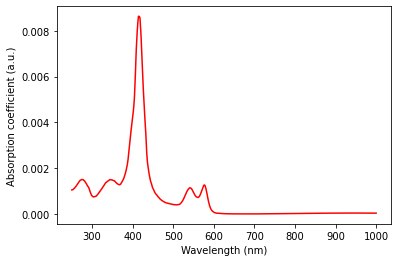

In [10]:
plt.figure()
plt.xlabel('Wavelength (nm)')
plt.ylabel('Absorption coefficient (a.u.)')
plt.plot(a_w0[:,1], a_w0[:,2],'r-')
plt.show()